# Facial Keypoint Detection
  
This project will be all about defining and training a convolutional neural network to perform facial keypoint detection, and using computer vision techniques to transform images of faces.  The first step in any challenge like this will be to load and visualize the data you'll be working with. 

Let's take a look at some examples of images and corresponding facial keypoints.

<img src='datasets/key_pts_example.png' width=50% height=50%/>

Facial keypoints (also called facial landmarks) are the small magenta dots shown on each of the faces in the image above. In images, there are faces and **keypoints, with coordinates (x, y)**.  These keypoints mark important areas of the face: the eyes, corners of the mouth, the nose, etc. These keypoints are relevant for a variety of tasks, such as face filters, emotion recognition, pose recognition, and so on.

---

## Load and Visualize Data

The first step in working with any dataset is to become familiar with your data; you'll need to load in the images of faces and their keypoints and visualize them! 

#### Training and Testing Data

This facial keypoints dataset consists of thousands gray images. All of these images are separated into either a training or a test set of data.

* training images are for you to use as you create a model to predict keypoints.
* test images are unknown to you, which will be used to test the accuracy of your model.

The information about the images and keypoints in this dataset are summarized in CSV files, which we can read in using `pandas`. Let's read the training CSV and get the annotations in an (N, 2) array where N is the number of keypoints and 2 is the dimension of the keypoint coordinates (x, y).

---

<div class="alert alert-info">
    <h3>Note</h3>
    <p>Sometimes you will be presented with csv data. The default python csv reader is ok, but for more efficient data manipulation, it is recommended to use <b>pandas</b>. We have not included pandas in the requirements file so you have to install it with <b>pip install pandas</b> before running the next cell.</p>
</div>

In [1]:
# import the required libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from exercise_code.vis_utils import show_all_keypoints


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

### Training data size

The training data is in csv file. There are 6750 images in training data, where the first 30 columns are the keypoints coordinates (x, y),
and the 31th column is the image content. We provide you the function `get_image` and `get_keypoints` function to get i-th image and i-th set of keypoints.

(6451, 31)


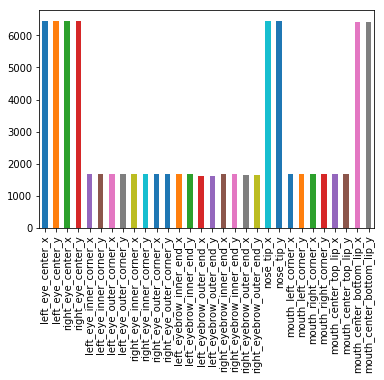

In [2]:
key_pts_frame = pd.read_csv('datasets/training.csv')
key_pts_frame.describe().loc['count'].plot.bar()
print(key_pts_frame.shape)

From visulization, we can see not every image contains full landmarks, therefore we need to delete those without full landmarks. And after dropping, we have almost 2k images left as our training data.

(1546, 31)


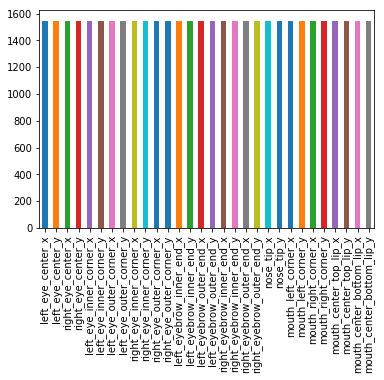

In [3]:
key_pts_frame.dropna(inplace=True)
key_pts_frame.describe().loc['count'].plot.bar()
print(key_pts_frame.shape)

In [4]:
from exercise_code.data_utils import get_keypoints
from exercise_code.data_utils import get_image

n = 0
image = get_image(n, key_pts_frame)
keypoints = get_keypoints(n, key_pts_frame)
print('image size: {}'.format(image.shape))
print('keypoints size: {}'.format(keypoints.shape))

image size: (96, 96)
keypoints size: (15, 2)


Below, is a function `show_all_keypoints` that takes in an image and keypoints and displays them.  As you look at this data, **note that these images are not all of the same quality**!

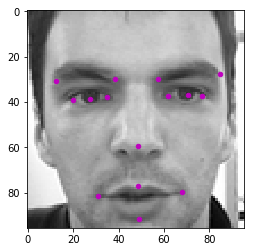

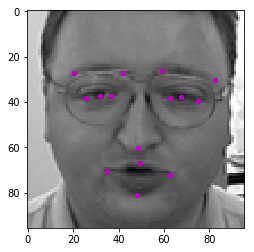

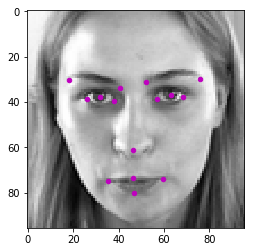

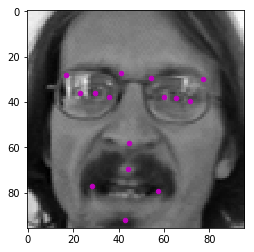

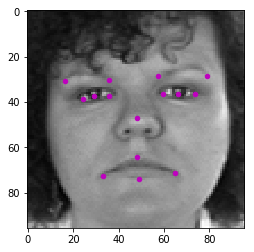

In [5]:
# select an image by index in our data frame
for n in range(5):
    image = get_image(n, key_pts_frame)
    key_pts = get_keypoints(n, key_pts_frame)
    show_all_keypoints(image, key_pts)

## Dataset class and Transformations

To prepare our data for training, we'll be using PyTorch's Dataset class. Much of this this code is a modified version of what can be found in the [PyTorch data loading tutorial](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

#### Dataset class

``torch.utils.data.Dataset`` is an abstract class representing a
dataset. This class will allow us to load batches of image/keypoint data, and uniformly apply transformations to our data, such as rescaling and normalizing images for training a neural network.


Your custom dataset should inherit ``Dataset`` and override the following
methods:

-  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
-  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
   be used to get the i-th sample of image/keypoint data.

Let's create a dataset class for our face keypoints dataset. We will
read the CSV file in ``__init__`` but leave the reading of images to
``__getitem__``.

A sample of our dataset will be a dictionary
``{'image': image, 'keypoints': key_pts}``. Our dataset will take an
optional argument ``transform`` so that any required processing can be
applied on the sample. We will see the usefulness of ``transform`` in the future. 
#### TODO: Implement a custom dataset for face keypoints in `exercise_code/dataloader.py` file

In [6]:
from exercise_code.dataloader import FacialKeypointsDataset

# Construct the dataset
face_dataset = FacialKeypointsDataset(csv_file='datasets/training.csv')

# print some stats about the dataset
print('Length of dataset: ', len(face_dataset))

Length of dataset:  1546


Now that we've defined this class, let's instantiate the dataset and display some images.

index: 0
image size: (1, 96, 96)
keypoint shape: (15, 2)


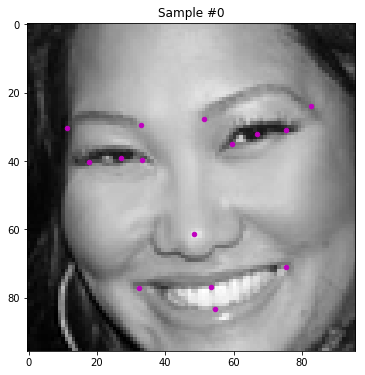

index: 1
image size: (1, 96, 96)
keypoint shape: (15, 2)


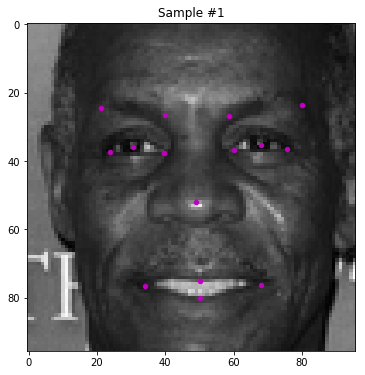

index: 2
image size: (1, 96, 96)
keypoint shape: (15, 2)


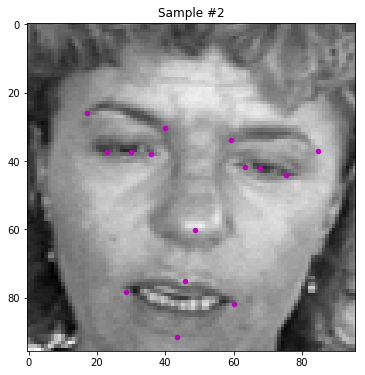

In [7]:
# Display a few of the images from the dataset
num_to_display = 3

for i in range(num_to_display):
    
    # define the size of images
    fig = plt.figure(figsize=(20,10))
    
    # randomly select a sample
    rand_i = np.random.randint(0, len(face_dataset))
    sample = face_dataset[rand_i]

    # print the shape of the image and keypoints
    print('index: {}'.format(i))
    print('image size: {}'.format(sample['image'].shape))
    print('keypoint shape: {}'.format(sample['keypoints'].shape))

    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title('Sample #{}'.format(i))
    
    # Using the same display function, defined earlier
    show_all_keypoints(sample['image'][0], sample['keypoints'])


## Transforms

Neural networks often expect images that are standardized; a fixed size, with a normalized range for color ranges and coordinates, and (for PyTorch) converted from numpy lists and arrays to Tensors.

Therefore, we will need to write some pre-processing code.
Let's create 2 transforms:

-  ``Normalize``: to convert grayscale values with a range of [0, 1] and normalize the keypoints to be in a range of about [-1, 1]
-  ``ToTensor``: to convert numpy images to torch images.


We will use the default transforms from torchvision

Observe below how these transforms are generally applied to both the image and its keypoints.



In [8]:
import torch
from torchvision import transforms, utils
# tranforms

from exercise_code.transforms import Normalize, ToTensor

## Test out the transforms

Let's test these transforms out to make sure they behave as expected. 

## Create the transformed dataset

Apply the transforms in order to normalized images and landmarks. Verify that your transform works by printing out the shape of the resulting data (printing out a few examples should show you a consistent tensor size).

#### Hint: you can also implement or use some other default PyTorch data augmenatiton methods to improve your scores! 

In [9]:
# define the data tranform
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Normalize(),
                                     ToTensor()])

# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='datasets/training.csv',
                                             transform=data_transform)

In [10]:
# print some stats about the transformed data
print('Number of images: ', len(transformed_dataset))

# make sure the sample tensors are the expected size
for i in range(1):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())


Number of images:  1546
0 torch.Size([1, 96, 96]) torch.Size([15, 2])


## Data Iteration and Batching

Right now, we are iterating over this data using a ``for`` loop, but we are missing out on a lot of PyTorch's dataset capabilities, specifically the abilities to:

-  Batch the data
-  Shuffle the data
-  Load the data in parallel using ``multiprocessing`` workers.

``torch.utils.data.DataLoader`` is an iterator which provides all these
features, and we'll see how this is used, when we load data in batches to train a neural network! Then we can define a DataLoader class from PyTorch with transformed dataset, with batch size 4, shuffle functionality and multithreading with 4 workers.

---



In [11]:
from torch.utils.data import DataLoader
batch_size = 20
train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


#### TODO: Define your model in the provided file `exercise_code/classifiers/keypoint_nn.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

In [12]:
from exercise_code.classifiers.keypoint_nn import KeypointModel
model = KeypointModel()
print(model)

KeypointModel(
  (seq1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ELU(alpha=1.0)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2)
    (8): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
    (9): ELU(alpha=1.0)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.3)
    (12): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
    (13): ELU(alpha=1.0)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.4)
  )
  (seq2): Sequential(
    (0): Linear(in_features=6400, out_features=1000, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.5)
    (3): Linear(in_features=1000, out_features=1000, 

keypoints shape
torch.Size([1, 15, 2])
index: 0
image shape: torch.Size([96, 96])
gt keypoints shape: torch.Size([15, 2])
predict keypoints shape: torch.Size([15, 2])


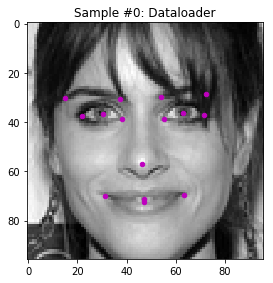

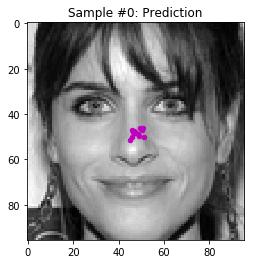

keypoints shape
torch.Size([1, 15, 2])
index: 0
image shape: torch.Size([96, 96])
gt keypoints shape: torch.Size([15, 2])
predict keypoints shape: torch.Size([15, 2])


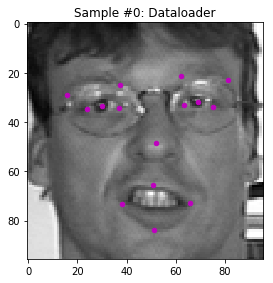

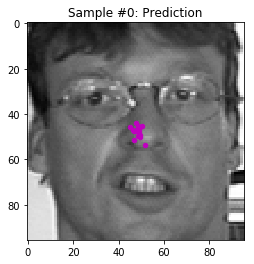

keypoints shape
torch.Size([1, 15, 2])
index: 0
image shape: torch.Size([96, 96])
gt keypoints shape: torch.Size([15, 2])
predict keypoints shape: torch.Size([15, 2])


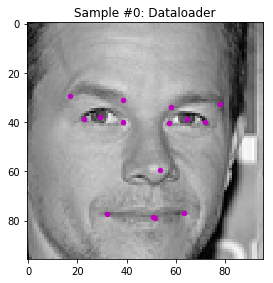

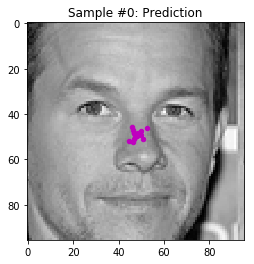

In [13]:
# Display a few output samples from our network
def show_sample_outputs(image, keypoints):    
    # define the size of images
    fig = plt.figure(figsize=(20,20))
    print("keypoints shape")
    print(keypoints.shape)
     
    # Predict with model
    predicted_keypoints = model(image)[0]
    # Cast back to (x,y)-coordinates
    predicted_keypoints = predicted_keypoints.view(-1, 2).detach()

    # Undo data normalization
    image = torch.squeeze(image) * 255.
    keypoints = (keypoints.view(-1, 2) * 48) + 48
    predicted_keypoints = (predicted_keypoints * 48) + 48

    # print the shape of the image and keypoints
    print('index: {}'.format(i))
    print('image shape: {}'.format(image.shape))
    print('gt keypoints shape: {}'.format(keypoints.shape))
    print('predict keypoints shape: {}'.format(predicted_keypoints.shape))
    
    # Print data loader image
    ax = plt.subplot(4, 1, 1)
    ax.set_title('Sample #{}: Dataloader'.format(i))
    # Using the same display function, defined earlier
    show_all_keypoints(image, keypoints)

    # Print predicted image
    ax = plt.subplot(1, 1, 1)
    ax.set_title('Sample #{}: Prediction'.format(i))
    # Using the same display function, defined earlier
    show_all_keypoints(image, predicted_keypoints)
    plt.show()
    
num_to_display = 3
for idx, sample in enumerate(train_loader):
    if idx == num_to_display:
        break
    show_sample_outputs(sample['image'][0:1], sample['keypoints'][0:1])

In [14]:
import torch.optim as optim
from torch import nn
from exercise_code.classifiers.keypoint_nn import KeypointModel

def train_net(n_epochs):

    # prepare the net for training
    model.train()
    running_loss = 0.0
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)
            #print(key_pts[0], images[0])

            # forward pass to get outputs
            output_pts = model(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()
            running_loss += loss.item()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1,
                                                                   batch_i+1,
                                                                   running_loss / (len(train_loader)*epoch+batch_i)))
            
            #return images, key_pts, output_pts

    print('Finished Training')

    
# Load model and run the solver

# From the paper:
# Adam optimizer, with learning rate of 0.001,
#  β1 of 0.9, β2 of 0.999 and ε of 1e − 08,
#  is used for minimizing Mean Squared Error (MSE).
model = KeypointModel()
criterion = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-6, nesterov=True)
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
train_net(n_epochs=300)

Epoch: 1, Batch: 10, Avg. Loss: 0.2178630514277352
Epoch: 1, Batch: 20, Avg. Loss: 0.1286010308877418
Epoch: 1, Batch: 30, Avg. Loss: 0.09321639587267719
Epoch: 1, Batch: 40, Avg. Loss: 0.07540156197949098
Epoch: 1, Batch: 50, Avg. Loss: 0.06319485523034724
Epoch: 1, Batch: 60, Avg. Loss: 0.05433338460654526
Epoch: 1, Batch: 70, Avg. Loss: 0.04784055469908576
Epoch: 2, Batch: 10, Avg. Loss: 0.03984990300096829
Epoch: 2, Batch: 20, Avg. Loss: 0.036662276277376206
Epoch: 2, Batch: 30, Avg. Loss: 0.034141986334922714
Epoch: 2, Batch: 40, Avg. Loss: 0.031933904131954044
Epoch: 2, Batch: 50, Avg. Loss: 0.030115013172131354
Epoch: 2, Batch: 60, Avg. Loss: 0.028469100275015743
Epoch: 2, Batch: 70, Avg. Loss: 0.027087022585249473
Epoch: 3, Batch: 10, Avg. Loss: 0.024996922125644756
Epoch: 3, Batch: 20, Avg. Loss: 0.023997504131070206
Epoch: 3, Batch: 30, Avg. Loss: 0.023095554392784833
Epoch: 3, Batch: 40, Avg. Loss: 0.022241741605103015
Epoch: 3, Batch: 50, Avg. Loss: 0.02150328539357316
Epoc

Epoch: 23, Batch: 10, Avg. Loss: 0.006047482440734039
Epoch: 23, Batch: 20, Avg. Loss: 0.006029235251967175
Epoch: 23, Batch: 30, Avg. Loss: 0.006014310538283093
Epoch: 23, Batch: 40, Avg. Loss: 0.005995065837095563
Epoch: 23, Batch: 50, Avg. Loss: 0.005976918653555995
Epoch: 23, Batch: 60, Avg. Loss: 0.005960999953258835
Epoch: 23, Batch: 70, Avg. Loss: 0.00594462863174828
Epoch: 24, Batch: 10, Avg. Loss: 0.00591579765936022
Epoch: 24, Batch: 20, Avg. Loss: 0.005898422381601266
Epoch: 24, Batch: 30, Avg. Loss: 0.005883202794390091
Epoch: 24, Batch: 40, Avg. Loss: 0.005868916793988557
Epoch: 24, Batch: 50, Avg. Loss: 0.005853084939932709
Epoch: 24, Batch: 60, Avg. Loss: 0.005837986373789387
Epoch: 24, Batch: 70, Avg. Loss: 0.005822756494406933
Epoch: 25, Batch: 10, Avg. Loss: 0.005793775218662225
Epoch: 25, Batch: 20, Avg. Loss: 0.005778724630203222
Epoch: 25, Batch: 30, Avg. Loss: 0.005763368420072609
Epoch: 25, Batch: 40, Avg. Loss: 0.005748982869735848
Epoch: 25, Batch: 50, Avg. Los

Epoch: 44, Batch: 60, Avg. Loss: 0.0043730019186051725
Epoch: 44, Batch: 70, Avg. Loss: 0.004367168024840748
Epoch: 45, Batch: 10, Avg. Loss: 0.004356161839533321
Epoch: 45, Batch: 20, Avg. Loss: 0.0043503378244479605
Epoch: 45, Batch: 30, Avg. Loss: 0.004344298620371924
Epoch: 45, Batch: 40, Avg. Loss: 0.004339117255928255
Epoch: 45, Batch: 50, Avg. Loss: 0.004334040454938511
Epoch: 45, Batch: 60, Avg. Loss: 0.004328556100239503
Epoch: 45, Batch: 70, Avg. Loss: 0.00432319961013009
Epoch: 46, Batch: 10, Avg. Loss: 0.004311875152168994
Epoch: 46, Batch: 20, Avg. Loss: 0.00430626001280407
Epoch: 46, Batch: 30, Avg. Loss: 0.004301807745549313
Epoch: 46, Batch: 40, Avg. Loss: 0.00429681989704945
Epoch: 46, Batch: 50, Avg. Loss: 0.004291377064593222
Epoch: 46, Batch: 60, Avg. Loss: 0.004286224450820806
Epoch: 46, Batch: 70, Avg. Loss: 0.004281796390961228
Epoch: 47, Batch: 10, Avg. Loss: 0.004273870515739113
Epoch: 47, Batch: 20, Avg. Loss: 0.004269176600910187
Epoch: 47, Batch: 30, Avg. Lo

Epoch: 66, Batch: 40, Avg. Loss: 0.0036995134591962576
Epoch: 66, Batch: 50, Avg. Loss: 0.0036965587518100968
Epoch: 66, Batch: 60, Avg. Loss: 0.003693581407167581
Epoch: 66, Batch: 70, Avg. Loss: 0.0036909894628649985
Epoch: 67, Batch: 10, Avg. Loss: 0.003686172397731752
Epoch: 67, Batch: 20, Avg. Loss: 0.0036829004957042713
Epoch: 67, Batch: 30, Avg. Loss: 0.003679652766811019
Epoch: 67, Batch: 40, Avg. Loss: 0.0036769844788448578
Epoch: 67, Batch: 50, Avg. Loss: 0.003674570736068496
Epoch: 67, Batch: 60, Avg. Loss: 0.003672303235012017
Epoch: 67, Batch: 70, Avg. Loss: 0.0036695134683503404
Epoch: 68, Batch: 10, Avg. Loss: 0.003665183147583637
Epoch: 68, Batch: 20, Avg. Loss: 0.0036626903935947286
Epoch: 68, Batch: 30, Avg. Loss: 0.0036604174336579785
Epoch: 68, Batch: 40, Avg. Loss: 0.0036580146052224557
Epoch: 68, Batch: 50, Avg. Loss: 0.0036550881887093115
Epoch: 68, Batch: 60, Avg. Loss: 0.0036523489220739256
Epoch: 68, Batch: 70, Avg. Loss: 0.0036503443890624977
Epoch: 69, Batch

Epoch: 88, Batch: 10, Avg. Loss: 0.0033311884704637367
Epoch: 88, Batch: 20, Avg. Loss: 0.0033291681436650746
Epoch: 88, Batch: 30, Avg. Loss: 0.0033273534951950216
Epoch: 88, Batch: 40, Avg. Loss: 0.0033256782134039663
Epoch: 88, Batch: 50, Avg. Loss: 0.0033239925573167787
Epoch: 88, Batch: 60, Avg. Loss: 0.003322421950172467
Epoch: 88, Batch: 70, Avg. Loss: 0.0033208636012516594
Epoch: 89, Batch: 10, Avg. Loss: 0.003318088845473564
Epoch: 89, Batch: 20, Avg. Loss: 0.0033169006687953913
Epoch: 89, Batch: 30, Avg. Loss: 0.0033152533759651186
Epoch: 89, Batch: 40, Avg. Loss: 0.003313703984857943
Epoch: 89, Batch: 50, Avg. Loss: 0.0033118596081932474
Epoch: 89, Batch: 60, Avg. Loss: 0.0033100923674581183
Epoch: 89, Batch: 70, Avg. Loss: 0.0033085060681485217
Epoch: 90, Batch: 10, Avg. Loss: 0.003305597202286956
Epoch: 90, Batch: 20, Avg. Loss: 0.0033040106414744088
Epoch: 90, Batch: 30, Avg. Loss: 0.003302385699244548
Epoch: 90, Batch: 40, Avg. Loss: 0.003300847565472956
Epoch: 90, Batch

Epoch: 109, Batch: 30, Avg. Loss: 0.003117524022975751
Epoch: 109, Batch: 40, Avg. Loss: 0.0031162795697277364
Epoch: 109, Batch: 50, Avg. Loss: 0.003115097735893053
Epoch: 109, Batch: 60, Avg. Loss: 0.003114086658612937
Epoch: 109, Batch: 70, Avg. Loss: 0.0031130501128288825
Epoch: 110, Batch: 10, Avg. Loss: 0.003111411843264714
Epoch: 110, Batch: 20, Avg. Loss: 0.003110367990612154
Epoch: 110, Batch: 30, Avg. Loss: 0.0031092557677981237
Epoch: 110, Batch: 40, Avg. Loss: 0.0031084541637491237
Epoch: 110, Batch: 50, Avg. Loss: 0.003107530450449592
Epoch: 110, Batch: 60, Avg. Loss: 0.0031065275090068948
Epoch: 110, Batch: 70, Avg. Loss: 0.0031055399239421407
Epoch: 111, Batch: 10, Avg. Loss: 0.003104262484346743
Epoch: 111, Batch: 20, Avg. Loss: 0.0031032025918057153
Epoch: 111, Batch: 30, Avg. Loss: 0.003102315082218018
Epoch: 111, Batch: 40, Avg. Loss: 0.0031012507287202134
Epoch: 111, Batch: 50, Avg. Loss: 0.0031006440567181875
Epoch: 111, Batch: 60, Avg. Loss: 0.003099606904821732
E

Epoch: 130, Batch: 40, Avg. Loss: 0.0029954838754756566
Epoch: 130, Batch: 50, Avg. Loss: 0.0029953567955314842
Epoch: 130, Batch: 60, Avg. Loss: 0.0029949082961868577
Epoch: 130, Batch: 70, Avg. Loss: 0.002994238763877372
Epoch: 131, Batch: 10, Avg. Loss: 0.002992960703716138
Epoch: 131, Batch: 20, Avg. Loss: 0.002992212899327289
Epoch: 131, Batch: 30, Avg. Loss: 0.002991779402819449
Epoch: 131, Batch: 40, Avg. Loss: 0.002991381240610638
Epoch: 131, Batch: 50, Avg. Loss: 0.00299083153034061
Epoch: 131, Batch: 60, Avg. Loss: 0.0029903072449703294
Epoch: 131, Batch: 70, Avg. Loss: 0.002989803462785815
Epoch: 132, Batch: 10, Avg. Loss: 0.00298898852153856
Epoch: 132, Batch: 20, Avg. Loss: 0.002988472003882295
Epoch: 132, Batch: 30, Avg. Loss: 0.00298796609697146
Epoch: 132, Batch: 40, Avg. Loss: 0.0029875893509380452
Epoch: 132, Batch: 50, Avg. Loss: 0.002987055355170728
Epoch: 132, Batch: 60, Avg. Loss: 0.002986646191639938
Epoch: 132, Batch: 70, Avg. Loss: 0.002986110722699261
Epoch: 1

Epoch: 151, Batch: 50, Avg. Loss: 0.002914935901461183
Epoch: 151, Batch: 60, Avg. Loss: 0.0029143894933687953
Epoch: 151, Batch: 70, Avg. Loss: 0.002913825417638435
Epoch: 152, Batch: 10, Avg. Loss: 0.002913001101480468
Epoch: 152, Batch: 20, Avg. Loss: 0.0029125199331899204
Epoch: 152, Batch: 30, Avg. Loss: 0.002912012507915866
Epoch: 152, Batch: 40, Avg. Loss: 0.0029114921876819883
Epoch: 152, Batch: 50, Avg. Loss: 0.0029109324081301236
Epoch: 152, Batch: 60, Avg. Loss: 0.0029105142437544263
Epoch: 152, Batch: 70, Avg. Loss: 0.0029099323376968397
Epoch: 153, Batch: 10, Avg. Loss: 0.0029091209634841022
Epoch: 153, Batch: 20, Avg. Loss: 0.0029087424344236127
Epoch: 153, Batch: 30, Avg. Loss: 0.002908346617543818
Epoch: 153, Batch: 40, Avg. Loss: 0.002907916409873293
Epoch: 153, Batch: 50, Avg. Loss: 0.0029074207391939564
Epoch: 153, Batch: 60, Avg. Loss: 0.0029069021577406338
Epoch: 153, Batch: 70, Avg. Loss: 0.002906615430981202
Epoch: 154, Batch: 10, Avg. Loss: 0.002905818178113898


Epoch: 172, Batch: 60, Avg. Loss: 0.002853916520345977
Epoch: 172, Batch: 70, Avg. Loss: 0.002853476938735584
Epoch: 173, Batch: 10, Avg. Loss: 0.002852567720445466
Epoch: 173, Batch: 20, Avg. Loss: 0.002852262896319257
Epoch: 173, Batch: 30, Avg. Loss: 0.0028520653023190214
Epoch: 173, Batch: 40, Avg. Loss: 0.0028518723456233334
Epoch: 173, Batch: 50, Avg. Loss: 0.0028514364373158126
Epoch: 173, Batch: 60, Avg. Loss: 0.002851121312695001
Epoch: 173, Batch: 70, Avg. Loss: 0.0028507642656002536
Epoch: 174, Batch: 10, Avg. Loss: 0.00285037356932777
Epoch: 174, Batch: 20, Avg. Loss: 0.002849945550790189
Epoch: 174, Batch: 30, Avg. Loss: 0.002849529375193928
Epoch: 174, Batch: 40, Avg. Loss: 0.0028491712152152186
Epoch: 174, Batch: 50, Avg. Loss: 0.0028487931755122797
Epoch: 174, Batch: 60, Avg. Loss: 0.0028482791702957445
Epoch: 174, Batch: 70, Avg. Loss: 0.002847779288553984
Epoch: 175, Batch: 10, Avg. Loss: 0.0028469876313140987
Epoch: 175, Batch: 20, Avg. Loss: 0.0028466011596468494
Ep

Epoch: 193, Batch: 70, Avg. Loss: 0.002806098041972396
Epoch: 194, Batch: 10, Avg. Loss: 0.002805567899638689
Epoch: 194, Batch: 20, Avg. Loss: 0.0028053050300921754
Epoch: 194, Batch: 30, Avg. Loss: 0.002805218287400441
Epoch: 194, Batch: 40, Avg. Loss: 0.002805122194106962
Epoch: 194, Batch: 50, Avg. Loss: 0.00280472794249528
Epoch: 194, Batch: 60, Avg. Loss: 0.0028043986542528997
Epoch: 194, Batch: 70, Avg. Loss: 0.0028041184492234826
Epoch: 195, Batch: 10, Avg. Loss: 0.0028036008137947797
Epoch: 195, Batch: 20, Avg. Loss: 0.002803251605893246
Epoch: 195, Batch: 30, Avg. Loss: 0.002803083763860009
Epoch: 195, Batch: 40, Avg. Loss: 0.002802750148043276
Epoch: 195, Batch: 50, Avg. Loss: 0.0028024435921883
Epoch: 195, Batch: 60, Avg. Loss: 0.0028021951750914396
Epoch: 195, Batch: 70, Avg. Loss: 0.002801918391765446
Epoch: 196, Batch: 10, Avg. Loss: 0.002801585501812952
Epoch: 196, Batch: 20, Avg. Loss: 0.002801321055659394
Epoch: 196, Batch: 30, Avg. Loss: 0.0028008992318155645
Epoch: 

Epoch: 215, Batch: 10, Avg. Loss: 0.002764433107389201
Epoch: 215, Batch: 20, Avg. Loss: 0.002764301207584229
Epoch: 215, Batch: 30, Avg. Loss: 0.0027640927724590808
Epoch: 215, Batch: 40, Avg. Loss: 0.002763845502299213
Epoch: 215, Batch: 50, Avg. Loss: 0.0027638034550760706
Epoch: 215, Batch: 60, Avg. Loss: 0.002763626660086556
Epoch: 215, Batch: 70, Avg. Loss: 0.0027636227794475537
Epoch: 216, Batch: 10, Avg. Loss: 0.002763629070992353
Epoch: 216, Batch: 20, Avg. Loss: 0.002763694118987342
Epoch: 216, Batch: 30, Avg. Loss: 0.0027634579527065803
Epoch: 216, Batch: 40, Avg. Loss: 0.0027633330975986364
Epoch: 216, Batch: 50, Avg. Loss: 0.0027632609683039843
Epoch: 216, Batch: 60, Avg. Loss: 0.0027632432055645036
Epoch: 216, Batch: 70, Avg. Loss: 0.0027630057126529542
Epoch: 217, Batch: 10, Avg. Loss: 0.0027628018286698724
Epoch: 217, Batch: 20, Avg. Loss: 0.002762729356373993
Epoch: 217, Batch: 30, Avg. Loss: 0.002762634322549012
Epoch: 217, Batch: 40, Avg. Loss: 0.002762457535060797
E

Epoch: 236, Batch: 20, Avg. Loss: 0.002734146569228674
Epoch: 236, Batch: 30, Avg. Loss: 0.002734076106983285
Epoch: 236, Batch: 40, Avg. Loss: 0.0027339264561531532
Epoch: 236, Batch: 50, Avg. Loss: 0.002733764386082882
Epoch: 236, Batch: 60, Avg. Loss: 0.002733521669546427
Epoch: 236, Batch: 70, Avg. Loss: 0.0027332563699458525
Epoch: 237, Batch: 10, Avg. Loss: 0.0027329456365611203
Epoch: 237, Batch: 20, Avg. Loss: 0.0027328285275954284
Epoch: 237, Batch: 30, Avg. Loss: 0.002732600427270366
Epoch: 237, Batch: 40, Avg. Loss: 0.0027324247482866
Epoch: 237, Batch: 50, Avg. Loss: 0.0027321615665238746
Epoch: 237, Batch: 60, Avg. Loss: 0.002731870451975926
Epoch: 237, Batch: 70, Avg. Loss: 0.002731642597780362
Epoch: 238, Batch: 10, Avg. Loss: 0.0027314450034179815
Epoch: 238, Batch: 20, Avg. Loss: 0.002731202465012243
Epoch: 238, Batch: 30, Avg. Loss: 0.002730835215143292
Epoch: 238, Batch: 40, Avg. Loss: 0.002730863614695325
Epoch: 238, Batch: 50, Avg. Loss: 0.0027307694434096103
Epoch

Epoch: 257, Batch: 30, Avg. Loss: 0.002710225536693291
Epoch: 257, Batch: 40, Avg. Loss: 0.0027101030670887145
Epoch: 257, Batch: 50, Avg. Loss: 0.002709896095850005
Epoch: 257, Batch: 60, Avg. Loss: 0.0027097428301689685
Epoch: 257, Batch: 70, Avg. Loss: 0.0027096587551320595
Epoch: 258, Batch: 10, Avg. Loss: 0.0027093285932541134
Epoch: 258, Batch: 20, Avg. Loss: 0.002709157600839442
Epoch: 258, Batch: 30, Avg. Loss: 0.0027090638104285743
Epoch: 258, Batch: 40, Avg. Loss: 0.002708809874221063
Epoch: 258, Batch: 50, Avg. Loss: 0.002708741157848882
Epoch: 258, Batch: 60, Avg. Loss: 0.002708586850369178
Epoch: 258, Batch: 70, Avg. Loss: 0.00270836231378149
Epoch: 259, Batch: 10, Avg. Loss: 0.0027082423757163964
Epoch: 259, Batch: 20, Avg. Loss: 0.002708224602468672
Epoch: 259, Batch: 30, Avg. Loss: 0.0027080600119764246
Epoch: 259, Batch: 40, Avg. Loss: 0.0027078526839341395
Epoch: 259, Batch: 50, Avg. Loss: 0.0027076813546030366
Epoch: 259, Batch: 60, Avg. Loss: 0.0027074913851742734
E

Epoch: 278, Batch: 40, Avg. Loss: 0.002691391936078888
Epoch: 278, Batch: 50, Avg. Loss: 0.0026912234742061092
Epoch: 278, Batch: 60, Avg. Loss: 0.0026911786824684895
Epoch: 278, Batch: 70, Avg. Loss: 0.0026911161586829174
Epoch: 279, Batch: 10, Avg. Loss: 0.002690962399200439
Epoch: 279, Batch: 20, Avg. Loss: 0.0026910737966212746
Epoch: 279, Batch: 30, Avg. Loss: 0.0026909179228107867
Epoch: 279, Batch: 40, Avg. Loss: 0.002690848631222088
Epoch: 279, Batch: 50, Avg. Loss: 0.0026907160702987994
Epoch: 279, Batch: 60, Avg. Loss: 0.0026905634891783116
Epoch: 279, Batch: 70, Avg. Loss: 0.0026904525338657843
Epoch: 280, Batch: 10, Avg. Loss: 0.0026905970806327803
Epoch: 280, Batch: 20, Avg. Loss: 0.002690533294147394
Epoch: 280, Batch: 30, Avg. Loss: 0.002690449116557218
Epoch: 280, Batch: 40, Avg. Loss: 0.0026903575945096286
Epoch: 280, Batch: 50, Avg. Loss: 0.002690335111756384
Epoch: 280, Batch: 60, Avg. Loss: 0.002690192877903031
Epoch: 280, Batch: 70, Avg. Loss: 0.0026901413149615764

Epoch: 299, Batch: 50, Avg. Loss: 0.002672277278214989
Epoch: 299, Batch: 60, Avg. Loss: 0.0026721074724560243
Epoch: 299, Batch: 70, Avg. Loss: 0.0026720485692787945
Epoch: 300, Batch: 10, Avg. Loss: 0.0026717235820795772
Epoch: 300, Batch: 20, Avg. Loss: 0.002671573637094269
Epoch: 300, Batch: 30, Avg. Loss: 0.0026713865698016833
Epoch: 300, Batch: 40, Avg. Loss: 0.002671334878652757
Epoch: 300, Batch: 50, Avg. Loss: 0.0026710706034998896
Epoch: 300, Batch: 60, Avg. Loss: 0.002670800671158502
Epoch: 300, Batch: 70, Avg. Loss: 0.002670692169810398
Finished Training


## Display the trained outputs

keypoints shape
torch.Size([15, 2])
index: 0
image shape: torch.Size([96, 96])
gt keypoints shape: torch.Size([15, 2])
predict keypoints shape: torch.Size([15, 2])


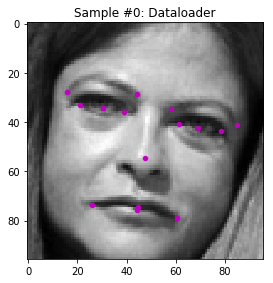

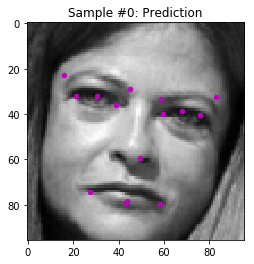

keypoints shape
torch.Size([15, 2])
index: 1
image shape: torch.Size([96, 96])
gt keypoints shape: torch.Size([15, 2])
predict keypoints shape: torch.Size([15, 2])


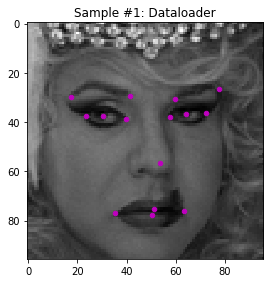

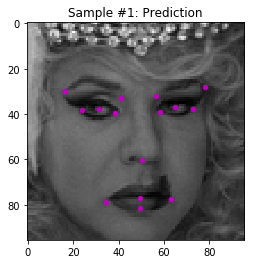

keypoints shape
torch.Size([15, 2])
index: 2
image shape: torch.Size([96, 96])
gt keypoints shape: torch.Size([15, 2])
predict keypoints shape: torch.Size([15, 2])


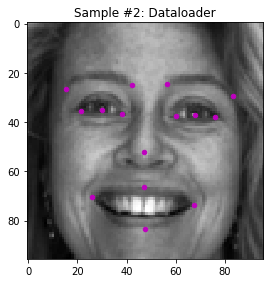

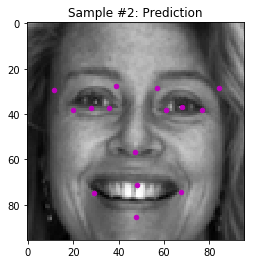

In [15]:
#show_sample_outputs(images[0:1], key_pts[0])

num_to_display = 3 
for i in range(num_to_display):
    sample = next(iter(train_loader))
    show_sample_outputs(sample['image'][0:1], sample['keypoints'][0])

## Validation on model
For our experiments, we use mean squared error (MSE) between the ground truth keypoint coordinate vector and the predicted keypoint coordinate vector. Given the ground truth vector and predict vector, MSE loss is defined as the average of the square of all of the error. 

#### Notice: the metric in this validation section is the same metric used in test evaluation.  You have to achieve more than 100 to get bonus.

In [16]:
def VAL_net():
    # prepare the net for training
    model.eval()
    running_loss = 0.0

    # train on batches of data, assumes you already have train_loader
    for batch_i, data in enumerate(val_loader):
        # get the input images and their corresponding labels
        images = data['image']
        key_pts = data['keypoints']

        # flatten pts
        key_pts = key_pts.view(key_pts.size(0), -1)

        # convert variables to floats for regression loss
        key_pts = key_pts.type(torch.FloatTensor)
        images = images.type(torch.FloatTensor)

        # forward pass to get outputs
        output_pts = model(images)

        # calculate the loss between predicted and target keypoints
        loss = criterion(output_pts, key_pts)

        # print loss statistics
        # to convert loss into a scalar and add it to the running_loss, use .item()
        running_loss += loss.item()
    # metric is 1 / (2 * MSE_loss)
    metric = 1.0 / (2 * (running_loss/len(val_loader)))
    print("Metric on VAL data: {}".format(metric))
    print('Finished Validation')
    
# create the validation dataset

VAL_dataset = FacialKeypointsDataset(csv_file='datasets/val.csv',
                                     transform=data_transform)
val_loader = DataLoader(VAL_dataset, 
                        batch_size=20,
                        shuffle=True, 
                        num_workers=4,
                        drop_last=True,
                       )
criterion = nn.MSELoss()
VAL_net()

Metric on VAL data: 363.53189617655545
Finished Validation


## Save the Model

When you are satisfied with your training, save the model for submission.

In [17]:
model.save("models/keypoints_nn.model")

Saving model... models/keypoints_nn.model
